### Guideline
\# TODO : ~~

목표에 맞게 코드를 작성하면 됩니다!

교재의 코드 참고해도 좋아요~

KoNLPy의 Okt를 사용하기 때문에 KoNLPy가 설치되어있어야 합니다!

이 노트북에서는 <b>'과제명' 피처만 사용하여 학습</b>시킵니다! 다른 피처도 사용하면 더 성능이 좋아질 가능성이 높겠죠? 나중에 시도해보시는 것 추천드려요b

# **1. 데이터 및 라이브러리 불러오기**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import os
import tqdm

from konlpy.tag import Okt

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score,f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

In [2]:
# TODO : 데이터 import (train, test, 자신의 데이터셋 위치 고려하여 작성!)
train = pd.read_csv('train.csv') # !
test = pd.read_csv('test.csv') # !
sample_submission = pd.read_csv('sample_submission.csv')

# **2. 데이터 EDA**

In [3]:
train.head(2)

,index,제출년도,사업명,사업_부처명,계속과제여부,내역사업명,과제명,요약문_연구목표,요약문_연구내용,요약문_기대효과,요약문_한글키워드,요약문_영문키워드,label
0,0,2016,농업기초기반연구,농촌진흥청,신규,농산물안전성연구,유전정보를 활용한 새로운 해충 분류군 동정기술 개발,○ 새로운 해충분류군의 동정기술 개발 및 유입확산 추적,(가) 외래 및 돌발해충의 발생조사 및 종 동정\n\n\n ○ 대상해충 : 최...,"○ 새로운 돌발 및 외래해충의 신속, 정확한 동정법 향상\n\n\n○ 돌발 및 외래...","뉴클레오티드 염기서열, 분자마커, 종 동정, 침샘, 전사체","nucleotide sequence, molecular marker, species...",24
1,1,2019,이공학학술연구기반구축(R&D),교육부,신규,지역대학우수과학자지원사업(1년~5년),대장암의 TRAIL 내성 표적 인자 발굴 및 TRAIL 반응 예측 유전자 지도 구축...,최종목표: TRAIL 감수성 표적 유전자를 발굴하고 내성제어 기전을 연구. 발굴된...,1차년도\n1) Microarray를 통한 선천적 TRAIL 내성 표적 후보 유전자...,"1) TRAIL 내성 특이적 표적분자를 발굴하고, 이를 이용한 TRAIL 효과 증진...","대장암,항암제 내성,세포사멸,유전자발굴","TRAIL,Colorectal cancer,TRAIL resistance,Apopt...",0


In [4]:
test.head(2)

,index,제출년도,사업명,사업_부처명,계속과제여부,내역사업명,과제명,요약문_연구목표,요약문_연구내용,요약문_기대효과,요약문_한글키워드,요약문_영문키워드
0,174304,2016,경제협력권산업육성,산업통상자원부,신규,자동차융합부품,R-FSSW 기술 적용 경량 차체 부품 개발 및 품질 평가를 위한 64채널 C-SC...,○ 차체 점용접부의 품질 검사를 위한 64채널 무선 기반 C-Scan 탐촉자 개발\...,○ 1차년도\n\n . 개발 탐촉 시스템의 성능 평가 위한 표준 시편 제작 시...,○ 기술적 파급효과\n\n - 본 연구에서 개발된 R-FSSW 접합 기술은 기존 ...,"마찰교반점용접, 비파괴 검사, 초음파 탐상, 씨 스캔, 용접 품질 평가","Friction Stir Spot Welding, Non-destructive ev..."
1,174305,2018,개인기초연구(과기정통부)(R&D),과학기술정보통신부,계속,신진연구(총연구비5천이상~1.5억이하),다입자계를 묘사하는 편미분방정식에 대한 연구,자연계에는 입자의 개수가 아주 큰 다양한 다입자계가 존재한다. 이런 다입자계의 효...,연구과제1. 무한입자계의 동역학 / 작용소(operator) 방정식에 대한 연구\n...,본 연구는 물리학에서 중요한 대상인 다입자계를 묘사하는 모델방정식의 정당성을 보장하...,"다체계 방정식,동역학의 안정성,양자역학,고전역학,평균장 극한,고전극한,비상대론적 극한","many particle system,stability of dynamics,qua..."


In [5]:
sample_submission.head(6)

,index,label
0,174304,0
1,174305,0
2,174306,0
3,174307,0
4,174308,0
5,174309,0


In [6]:
# 데이터 구조 파악
print(train.shape)
print(test.shape)
print(sample_submission.shape)

(174304, 13)
(43576, 12)
(43576, 2)


### 시각화
#### 레이블 분포

0     142571
19      4938
24      3520
23      1840
5       1698
14      1672
18      1550
1       1261
45      1137
36      1060
20      1059
29      1028
31       922
25       810
10       658
27       620
13       575
33       533
34       523
16       506
21       496
28       449
40       441
43       351
8        339
26       316
35       291
2        275
12       268
37       266
38       262
32       260
30       234
39       202
11       200
15       165
17       154
22       148
3        143
7        113
9        106
44        91
6         78
41        67
4         57
42        51
Name: label, dtype: int64


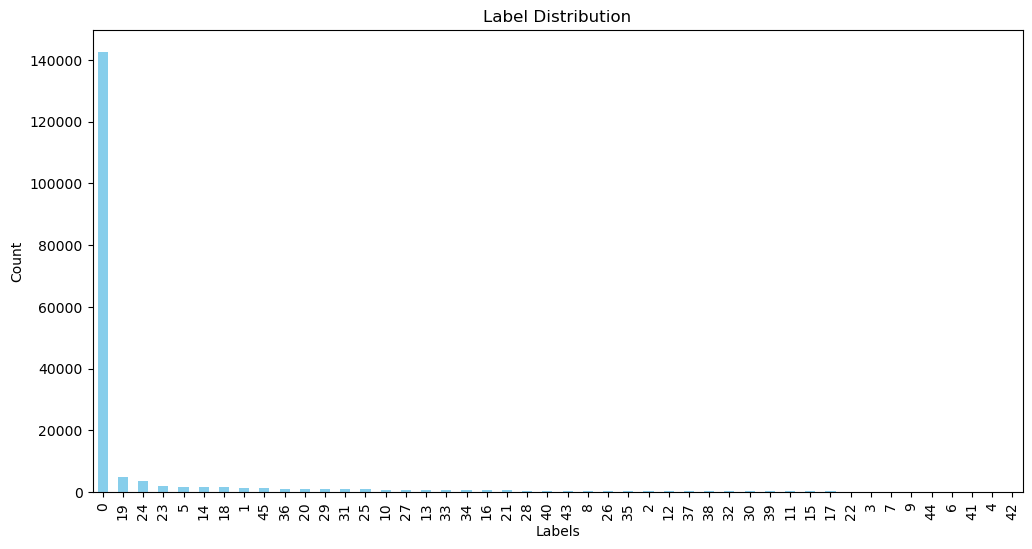

In [9]:
# 레이블 분포 확인
label_counts = train['label'].value_counts()
print(label_counts)

# 레이블 분포 시각화
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

80% 이상을 0 레이블이 차지합니다.

불균형한 레이블 분포이고, 데이터 건수가 너무 많기 때문에 언더 샘플링, SMOTE 오버샘플링을 수행합니다.

</br>

#### 텍스트 길이

텍스트분석에서 <b>텍스트의 길이 분석이 도움되는 점</b>
1. 전처리 결정
- 이상치 제거
- 데이터 불균형 탐지 및 처리
2. 모델 선택 및 설정
- 텍스트 길이 따른 적절한 모델 선택 <br>
긴 텍스트를 처리해야 하는 경우, 단순한 모델보다 LSTM이나 Transformer와 같은 더 복잡한 모델이 필요할 수 있다.
3. 패딩 전략 수립 <br>
시퀀스 모델에서 입력 길이를 맞추기 위해 패딩을 사용할 때, 적절한 최대 시퀀스 길이를 설정하는 데 도움이 된다.<br><br>
등등...
<br>
<b>하지만 이 노트북에서는 단순한 전처리만 할 예정입니다. 참고만 해주세요!</b>

과제명 길이 최댓값: 229
과제명 길이 최솟값: 2
과제명 길이 평균값: 35.84252225995961
과제명 길이 중간값: 34.0


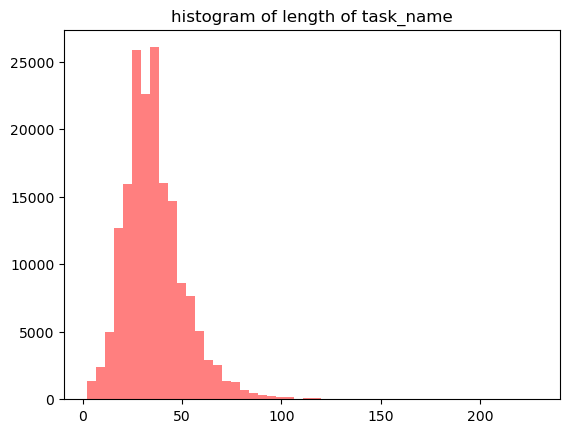

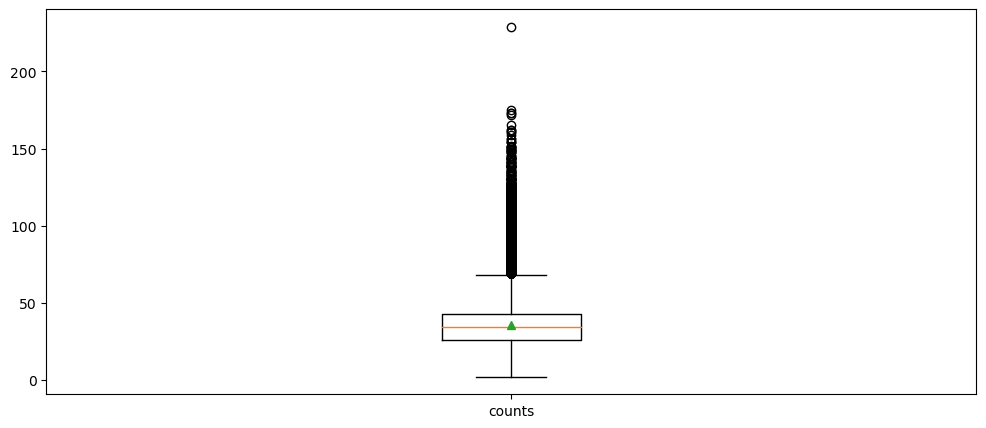

In [11]:
length=train['과제명'].astype(str).apply(len)
plt.hist(length, bins=50, alpha=0.5, color='r', label='word') # 히스토그램 그리기 (bins = 구간 개수, label = 해당 그래프 데이터 레이블)
plt.title('histogram of length of task_name')
plt.figure(figsize=(12, 5))
plt.boxplot(length, labels=['counts'], showmeans=True)
print('과제명 길이 최댓값: {}'.format(np.max(length)))
print('과제명 길이 최솟값: {}'.format(np.min(length)))
print('과제명 길이 평균값: {}'.format(np.mean(length)))
print('과제명 길이 중간값: {}'.format(np.median(length)))

# **3. 데이터 전처리**

'과제명'만 학습에 사용합니다.

In [16]:
X_train = train[['과제명']]
y_train = train[['label']]
test = test[['과제명']]

In [17]:
X_train.head(2)

,과제명
0,유전정보를 활용한 새로운 해충 분류군 동정기술 개발
1,대장암의 TRAIL 내성 표적 인자 발굴 및 TRAIL 반응 예측 유전자 지도 구축...


In [18]:
y_train.head(2)

,label
0,24
1,0


In [19]:
test.head(2)

,과제명
0,R-FSSW 기술 적용 경량 차체 부품 개발 및 품질 평가를 위한 64채널 C-SC...
1,다입자계를 묘사하는 편미분방정식에 대한 연구


In [20]:
# 전처리 함수 정의
def preprocessing(text, okt, remove_stopwords=False, stop_words=[]):
    # TODO : 한글 및 공백만 남기고 제거하기 (힌트: OO.OOO(r'한글 및 공백 제외 문자', '', OOOO) / 교재 521p 참고)
    text = re.sub(r'[^가-힣\s]', '', text) # !
    # TODO : okt로 형태소 분석 (0000, stem = True)
    word_text = okt.morphs(text, stem=True) # !
    # stop word 제거
    if remove_stopwords:
        word_review=[token for token in word_text if not token in stop_words]
    return word_review

# stop word(불용어) 리스트
stop_words=['은','는','이','가', '하','아','것','들','의','있','되','수','보','주','등','한']

# TODO : Okt 객체 생성
okt = Okt() # !

In [22]:
# 훈련 데이터 및 테스트 데이터 전처리
clean_train_text = []
clean_test_text = []

# 데이터 건수가 많아 오래걸립니다.
for text in tqdm.tqdm(X_train['과제명']):
    try:
        clean_train_text.append(preprocessing(text, okt, remove_stopwords=True, stop_words=stop_words))
    except:
        clean_train_text.append([])

for text in tqdm.tqdm(test['과제명']):
    if isinstance(text, str):
        clean_test_text.append(preprocessing(text, okt, remove_stopwords=True, stop_words=stop_words))
    else:
        clean_test_text.append([])

100%|███████████████████████████████████████████████████████████████████████████| 43576/43576 [02:02<00:00, 354.72it/s]


In [23]:
len(clean_train_text)

174304

In [24]:
len(clean_test_text)

43576

In [25]:
# TODO: 피처 벡터화

# 1. CountVectorizer, TfidfVectorizer 모듈 임포트
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# 2. CountVectorizer 객체 생성 / 이름: cnt_vect, (파라미터: tokenizer = lamda x : x, lowercase = False)
# tokenizer 인자에는 list를 받아서 그대로 내보내는 함수를 넣어줍니다. 또한 소문자화를 하지 않도록 설정해야 에러가 나지 않습니다.
cnt_vect = CountVectorizer(tokenizer = lambda x : x, lowercase = False)
# 학습 데이터 피처 벡터화 / 이름: cnt_train_features
train_features_cnt = cnt_vect.fit_transform(clean_train_text)
# 테스트 데이터 피처 벡터화 / 이름: cnt_tst_features (fit_transform / fit / transform 중 뭐가 맞을까요?)
test_features_cnt = cnt_vect.transform(clean_test_text)

# TfidfVectorizer 객체 생성 / 이름: tfidf_vect, (파라미터: tokenizer = lamda x : x, lowercase = False)
tfidf_vect = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
# CountVectorizer처럼 학습, 테스트 데이터 피처 벡터화 / 이름: tfidf_train_features, tfidf_test_features
train_features_tfidf = tfidf_vect.fit_transform(clean_train_text)
test_features_tfidf = tfidf_vect.transform(clean_test_text)

C:\Users\silve\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


시간 상의 문제로 TF-IDF 벡터화한 데이터셋으로 계속 진행합니다.

In [29]:
# 언더 샘플링 및 SMOTE 오버 샘플링
# *imbalanced-learn 파이썬 패키지가 설치되어 있어야 합니다. (분류 챕터 숙제하셨다면 설치완료!)
# 아나콘다 프롬프트에서 관리자 권한 실행 -> conda install -c conda-forge imbalanced-learn 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# 언더 샘플링
under_sampler = RandomUnderSampler(
        sampling_strategy={0: 5000}, # 0 레이블을 5000개로 감소
        random_state=42
        )
X_under, y_under = under_sampler.fit_resample(train_features_tfidf, y_train)

# SMOTE 오버 샘플링
smote = SMOTE(
        sampling_strategy='not majority',  # 다수 클래스 제외한 나머지만 증가
        random_state=42,
        k_neighbors=5
        )
X_balanced, y_balanced = smote.fit_resample(X_under, y_under) 

In [30]:
# 최종 학습 피처 데이터 세트
X_balanced

<230000x25630 sparse matrix of type '<class 'numpy.float64'>'
	with 3786017 stored elements in Compressed Sparse Row format>

In [33]:
# 최종 학습 레이블 데이터 세트
y_balanced.label.value_counts(sort=False)

0     5000
1     5000
2     5000
3     5000
4     5000
5     5000
6     5000
7     5000
8     5000
9     5000
10    5000
11    5000
12    5000
13    5000
14    5000
15    5000
16    5000
17    5000
18    5000
19    5000
20    5000
21    5000
22    5000
23    5000
24    5000
25    5000
26    5000
27    5000
28    5000
29    5000
30    5000
31    5000
32    5000
33    5000
34    5000
35    5000
36    5000
37    5000
38    5000
39    5000
40    5000
41    5000
42    5000
43    5000
44    5000
45    5000
Name: label, dtype: int64

# **4. 모델링**

In [34]:
# 훈련 데이터 셋과 검증 데이터 셋으로 분리
TEST_SIZE=0.2
RANDOM_SEED=42

# TODO: 빈칸 채우기!
train_x, eval_x, train_y, eval_y=train_test_split(X_balanced, y_balanced, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [39]:
# TODO: 랜덤포레스트로 모델링
# 랜덤포레스트 모듈 임포트
from sklearn.ensemble import RandomForestClassifier
# RandomForestClassifier 모델 생성 (결정 트리 개수 100개, verbose = 1, n_jobs = -1)
forest = RandomForestClassifier(n_estimators = 100, verbose = 1, n_jobs = -1)
# 학습 데이터로 모델 훈련
forest.fit(train_x, train_y)

C:\Users\silve\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished


RandomForestClassifier(n_jobs=-1, verbose=1)

In [40]:
# TODO: 모델 검증 (빈칸 채우기)
forest.score(eval_x, eval_y)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.6s finished


0.9781739130434782

# **5. 예측 및 제출**

In [43]:
# TODO: 피처 벡터화한 테스트 데이터에 대한 랜덤포레스트 모델 예측, test_predictions에 저장
test_predictions = forest.predict(test_features_tfidf)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished


In [44]:
# TODO: 샘플 제출용 데이터프레임에 예측 결과 업데이트 (빈칸 채우기)
sample_submission['label'] = test_predictions

In [45]:
sample_submission.head(10)

,index,label
0,174304,18
1,174305,0
2,174306,0
3,174307,19
4,174308,1
5,174309,16
6,174310,13
7,174311,0
8,174312,0
9,174313,14


In [46]:
# 제출할 예측 결과 파일 생성!
sample_submission.to_csv('submission0.csv', index=False)

직접 사이트에 제출해보셔도 됩니다!

점수는.. 기대 안하시는게..